#  <center> #FUNWITHDATA </center>
     
#### <center>Notebook 2 : Multiple Linear Regression</center>


This is the second notebook in my series on modelling for car emissions prediction models. Please go through the first notebook on [Simple Linear rgression on car emissions](https://github.com/wgova/Car_emissions/blob/master/Car%20emissions%20-%20Simple-Linear-Regression.ipynb) where the data is preprocessed and preliminary prediction power of variables is investigated using **Pearson Coefficients**. This notebook follows on modelling with variables identified to have a strong coerrelation and modelling power.

### Packages needed

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
from scipy.stats import pearsonr
%matplotlib inline

### Downloading and reading the data
The data is available in my respository along with the notebookT for download. 

In [11]:
data = "../Data/Car_Emissions_Fuel.csv"
df = pd.read_csv(data)

In [12]:
df.describe()

,Unnamed: 0,MODELYEAR,ENGINESIZE,CYLINDERS,City_FC,HWY_FC,COMB_FC,COMB_MPG_FC,CO2EMISSIONS,Diesel,Ethanol,Gasoline,Prem_Gasoline
count,1067.000000,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,533.000000,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679,0.025305,0.086223,0.481724,0.406748
std,308.160672,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304,0.157122,0.280825,0.499900,0.491457
min,0.000000,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000,0.000000,0.000000,0.000000,0.000000
25%,266.500000,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000,0.000000,0.000000,0.000000,0.000000
50%,533.000000,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000,0.000000,0.000000,0.000000,0.000000
75%,799.500000,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000,0.000000,0.000000,1.000000,1.000000
max,1066.000000,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df.describe(include='object')

,MAKE,MODEL,VEHICLECLASS,TRANSMISSION
count,1067,1067,1067,1067
unique,39,663,16,22
top,FORD,F150 FFV 4X4,MID-SIZE,A6
freq,90,8,178,222


## Subsetting for modelling

Lets select some features that we want to use for regression.

In [17]:
inputs_df = df[['ENGINESIZE','Gasoline','Prem_Gasoline','CO2EMISSIONS']]
target = df.CO2EMISSIONS
varrs = inputs_df.drop(['CO2EMISSIONS'],axis = 1)

In [18]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [19]:
df_corr = inputs_df.corr()
pval = calculate_pvalues(inputs_df) 
# create three masks for p-values
r1 = df_corr.applymap(lambda x: '{:.2f}*'.format(x)) 
r2 = df_corr.applymap(lambda x: '{:.2f}**'.format(x))
r3 = df_corr.applymap(lambda x: '{:.2f}***'.format(x))
r4 = df_corr.applymap(lambda x: '{:.2f}'.format(x))
# applying these masks to the correlation matrix
df_corr = df_corr.mask(pval>.1,r4)
df_corr = df_corr.mask(pval<=.1,r1)
df_corr = df_corr.mask(pval<=.05,r2)
df_corr = df_corr.mask(pval<=.01,r3)
df_corr

,ENGINESIZE,Gasoline,Prem_Gasoline,CO2EMISSIONS
ENGINESIZE,1.00***,-0.27***,0.17***,0.87***
Gasoline,-0.27***,1.00***,-0.80***,-0.23***
Prem_Gasoline,0.17***,-0.80***,1.00***,0.16***
CO2EMISSIONS,0.87***,-0.23***,0.16***,1.00***


## Description of the data

The data contains a 2014 fuel consumption dataset with model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. For the pursposes of this project, only numerical variables will be extracted for modelling. 

- **MAKE** e.g. Acura
- **MODEL** include 4WD/4X4 = Four-wheel drive,  AWD = All-wheel drive, CNG = Compressed natural gas, FFV = Flexible-fuel vehicle, NGV = Natural gas vehicle
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** A = Automatic, AM = Automated manual, AS = Automatic with select shift, AV = Continuously variable, M = Manual, 3 – 10 = Number of gears
- **FUEL CONSUMPTION (City,HWY,COMB)** City and highway fuel consumption ratings litres per 100 kilometres (L/100 km) - combined rating (55% city, 45% hwy) in L/100 km and in miles per gallon (mpg)
- **CO2 EMISSIONS (g/km)** Estimated tailpipe carbon dioxide emissions (in grams per kilometre) based on fuel type and the combined fuel consumption rating.
- **FUELTYPE** - X = Regular gasoline, Z = Premium gasoline, D = Diesel, E = Ethanol (E85), N = Natural Gas


#### Create training and testing dataset from our 
The dataset is split into training and testing sets, in the ratio 70%: 30% respectively using a mask to select random rows.

In [31]:
from sklearn.model_selection import train_test_split as tts

# Split data into test (30%) and training (70%) sets
train_data, test_data = tts(inputs_df,train_size=0.8)

print("Training samples", train_data.shape[0])
print("Testing samples: ", test_data.shape[0])

('Training samples', 853)
('Testing samples: ', 214)


## Multiple Regression Model


At this point, it is important to go back to the question and ensure our model is fit-for-purpose. Firstly, our model must predict car features that maximise carbon emissions. With this in mind, only features with a strong positive correlation will be useful, but in reality, the negative correlations will reduce the emissions predicted by our model. We should keep this in mind for now. Secondly, in order to select variables that have a strong linear relationship, we will start by evaluating features that **maximise R-squared and minimise MSE (RMSE)**

The most important ones for now are (ranked in order of importance):
 - ENGINESIZE
 - Gasoline 
 - Prem gasoline

In [23]:
# To fit the regression line to the test data
from sklearn.linear_model import LinearRegression as lreg
# For calculating model metrics
from sklearn import metrics
from sklearn.metrics import r2_score

In [32]:
# Extract the training data for emissions
y = train_data.CO2EMISSIONS

In [33]:
# Define regression lines for data subsets 
line = lreg()

In [37]:
# Extract the data subsets to be fitted to the regression line
x = train_data[['ENGINESIZE','Gasoline','Prem_Gasoline']]

In [38]:
line.fit(x,y) # Train the model with the full training data set

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Ordinary Least Squares (OLS)

Scikit-learn uses plain Ordinary Least Squares method to solve the intercept and coefficients of the hyperplane. OLS is a method for estimating the unknown parameters in a linear regression model by minimizing the **sum of squared errors (SSE)** or **mean squared error (MSE)** between the target variable (y) and our predicted output (y-hat) over all samples in the dataset. OLS finds the best parameters by:
- Solving the model parameters analytically using closed-form equations
- Using an optimization algorithm (Gradient Descent, Stochastic Gradient Descent, Newton’s Method, etc.)

#### Model evaluation

First, a visualisation of the test resulsts can help us make a quick judgement call on how good our model is

In [39]:
y_test = test_data[['CO2EMISSIONS']]

In [40]:
# Create data subsets for modelling
x_test = test_data[['ENGINESIZE','Gasoline','Prem_Gasoline']]

In [41]:
# Test the model by predicting values for the test data set
y_pred = line.predict(x_test)

In [42]:
import seaborn as sns 
def DistributionPlot(RedFunction,BlueFunction,RedName,BlueName,Title,xlabel ): # 
    #width = 4 ; height = 4
    #plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, kde=True, 
                       color="grey", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, 
                       color="blue", label=BlueName, ax=ax1)
    
    plt.title(Title)
    plt.xlabel(xlabel)
    plt.ylabel("Carbon dioxide Emissions"); plt.show; #plt.close()

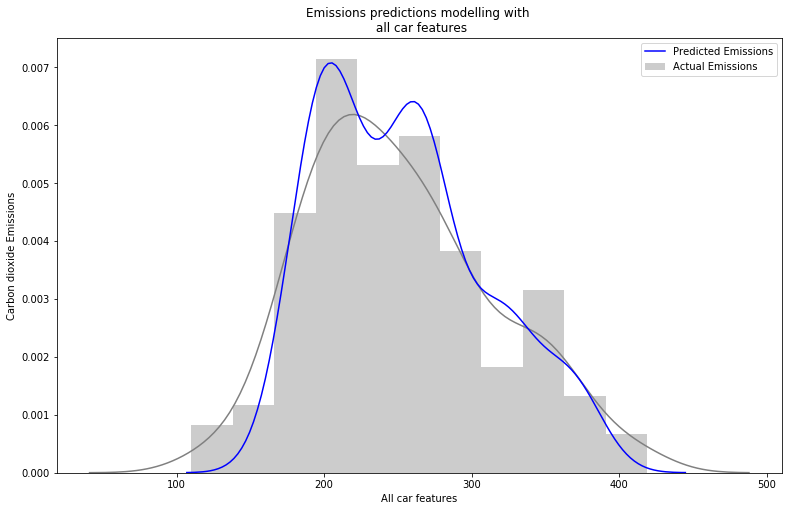

In [45]:
plt.figure(figsize=(13,8))
DistributionPlot(y_test,y_pred,"Actual Emissions","Predicted Emissions",
                 "Emissions predictions modelling with \n all car features","All car features")

##### Mathematical Model Evaluation metrics

As with Simple linear regression, the objective is to maximise the explained variance ($R-squared$), and minimise the average error, or mean square error (MSE), therefore, its root - root mean square error (RMSE).

Each of these scores is calculated as shown in the calculations below:

In [66]:
#Calculate each individual variance score for selected models to be evaluated (*100 to fit the scale)
#Store the results in a variable to be used later for plotting 
r2_all = 100*r2_score(y_test,y_pred)
rmse_all = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print('R-squared:',r2_all,'RMSE:',rmse_all)

('R-squared:', 78.14824474567119, 'RMSE:', 29.671341962188755)


In [48]:
#Calculate each individual RMSE value for selected models to be evaluated
#Store the results in a variable to be used later for plotting


In [ ]:
# Calculate metrics for the 'All-features' MLR model
#print("Explained variance score (R-squared): %.2f" % r2_all) # Calculate R-sqrd for the model using test data set
#print("RMSE:%.2f" % rmse_all)
#print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
#print("MSE:%.2f" % metrics.mean_squared_error(y_test, y_pred))

In [ ]:
# Calculate metrics for the 'All-features' MLR model
#print("R-squared (Variance score): %.2f" % r2_score(y_test, y_pred_City))
#print("RMSE:%.2f" %  np.sqrt(metrics.mean_squared_error(y_test, y_pred_City)))
#print("MSE:%.2f" % metrics.mean_squared_error(y_test, y_pred_City))
#print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred_City))

In [ ]:
# Calculate metrics for the 'All-features' MLR model
#print("R-squared (Variance score): %.2f" % r2_score(y_test, y_pred_Hwy))
#print("RMSE:%.2f" %  np.sqrt(metrics.mean_squared_error(y_test, y_pred_Hwy)))
#print("MSE:%.2f" % metrics.mean_squared_error(y_test, y_pred_Hwy))
#print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred_Hwy))

In [ ]:
# Calculate metrics for the 'All-features' MLR model
#print("R-squared (Variance score): %.2f" % r2_score(y_test, y_pred_City_Hwy))
#print("RMSE:%.2f" %  np.sqrt(metrics.mean_squared_error(y_test, y_pred_City_Hwy)))
#print("MSE:%.2f" % metrics.mean_squared_error(y_test, y_pred_City_Hwy))
#print("MAE: %.2f" % metrics.mean_absolute_error(y_test, y_pred_City_Hwy))

Create a dataframe with all the scores (RMSE and Exaplained Variance) for the different MLR models  

In [ ]:
# Create a list the row labels for row entries for the scores data
features = ['All_8(+Gasoline \n Prem_Gasoline)','Excl City_FC','Excl HWY_FC','Excl Gasoline','Excl Prem_Gasoline',
            'Excl COMB_MPG_FC','Excl COMB_FC','Excl ENGINESIZE','Excl CYLINDERS','Excl City_FC \n & HWY_FC',
            'Excl Gasoline & \n Prem_Gasoline','Excl COMB_MPG_FC &\n HWY_FC']

# Create a list to store row entries for RMSE 
rmse = [rmse_all,rmse_City,rmse_Hwy, rmse_Gas,rmse_PGas,rmse_CMPG,rmse_CFC,rmse_ES,rmse_Cy,rmse_City_Hwy,rmse_G_PGas, 
        rmse_CMPG_Hwy]

# Create a list to store row entries for Explained variance 
rsqr = [r2_all,r2_City,r2_Hwy, r2_Gas,r2_PGas,r2_CMPG,r2_CFC,r2_ES,r2_Cy,r2_City_Hwy,r2_G_PGas, r2_CMPG_Hwy]

# Create dictionary to convert and store the scores into columns 
slr_evaluation = {'Feature': features, 'Root Mean \n Square Error (RMSE)': rmse,'Explained variance (%)': rsqr}

# Convert the dictionary into dataframes
slr_df = pd.DataFrame(slr_evaluation, columns=['Feature','Root Mean \n Square Error (RMSE)', 'Explained variance (%)'])
slr_df.head(2)

In [ ]:
#df = slr_df.groupby(['Feature'])['Root Mean \n Square Error','R2-score (%)'].sum()
#df.plot.barh(legend=True) #(kind='bar')

Plot the results of the scores in a horizontal bar graph to compare the different models 

In [ ]:
scores = slr_df[[ 'Root Mean \n Square Error (RMSE)','Explained variance (%)']]

ax = scores.plot(kind='barh', figsize=(10,8), 
                 color=['blue','slategray'],legend = True,fontsize=12);
ax.set_alpha(0.1)
ax.set_title("Summary of Multilinear regression (MLR) model scores", fontsize=18)
ax.set_xlabel("Model score", fontsize=10)
ax.set_ylabel("Car features used or excluded (Excl) in MLR model", 
              fontsize=12)
ax.set_xticks([10,20,30,40,50,60,70,80,90,100])
ax.set_yticklabels(slr_df["Feature"])
legend = ax.legend(loc='lower center',shadow=True,fontsize='large')
legend.get_frame().set_facecolor('C9')
# set individual bar labels using 'yticklabels'
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y()+0.1, \
            str(round((i.get_width()), 2)), fontsize=12, color='black',rotation=0)

# invert for largest on top 
ax.invert_yaxis()

Thank you for taking time to go through my notebook. Please share your suggestions and criticisms on my GitHub.

<a href="https://wgova.github.io/Profile/"><img src = "https://wgova.github.io//Profile/assets/images/profile.png" width = 100, align = "center"></a>